# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os
# from sodapy import Socrata

# Datetime
import datetime as datetime

import snowflake.connector
# Date
import datetime as dt
import time
from datetime import timedelta

#Math
from math import exp

In [2]:
# # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )
# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

In [3]:
# cur = conn.cursor()
# print(conn)

# cur.execute("SHOW DATABASES")

# for db in cur:
#     print(db)

# Execute a statement that will generate a result set WAREHOUSE.GOLD.SUBSCRIPTION_RETENTION
# sql = "select * from GOLD.SUBSCRIPTION_RETENTION"
# cur.execute(sql)









# reads data into pandas
# df = cur.fetch_pandas_all()
# df.head()

## Acuity

In [4]:
silver = pd.read_csv('SILVER_FACT.ACUITY_ND_CONSULT_EVENTS.csv')
silver.head()

,EVENT_TS,EVENT_TS_UTC,ANONYMOUS_ID,EVENT,APPOINTMENT_BODY_CALENDAR,APPOINTMENT_BODY_FIRST_NAME,APPOINTMENT_BODY_DATETIME_CREATED,APPOINTMENT_BODY_CALENDAR_ID,APPOINTMENT_BODY_CALENDAR_TIMEZONE,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_BODY_TIMEZONE,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_LAST_NAME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_ID,APPOINTMENT_TYPE_ID,APPOINTMENT_BODY_CANCELED,APPOINTMENT_BODY_NO_SHOW
0,2020-12-23 23:45:03.646,2020-12-24 07:45:03.646,495876669,appointment_scheduled,"Dr. Anya Arthen, ND",Hunter,2020-12-24 01:45:00.000,3513713.0,America/New_York,hunterelliott510@gmail.com,"December 29, 2020",20.0,America/Los_Angeles,2020-12-29 14:25:00.000,Elliott,Hair Consultation,495876669.0,12047150.0,False,NaN
1,2021-01-03 00:03:41.860,2021-01-03 08:03:41.860,499867827,appointment_scheduled,"Dr. Nicole Klughers, ND",Kathleen,2021-01-03 02:03:40.000,3513704.0,America/New_York,katmc@sbcglobal.net,"January 21, 2021",20.0,America/Los_Angeles,2021-01-21 17:00:00.000,McElhinney,Hair Consultation,499867827.0,12799707.0,False,NaN
2,2020-12-27 21:34:32.762,2020-12-28 05:34:32.762,496859072,appointment_scheduled,"Dr. Nadia Musavvir, ND",ashley,2020-12-27 23:34:29.000,3513708.0,America/Chicago,ashleynizzle@yahoo.com,"January 6, 2021",20.0,America/Chicago,2021-01-06 12:30:00.000,patkovic,Hair Consultation,496859072.0,12799707.0,False,NaN
3,2020-11-27 03:05:47.644,2020-11-27 11:05:47.644,481523073,appointment_scheduled,"Dr. Ariana Zastrow, ND",Rose,2020-11-27 05:05:44.000,3684820.0,America/New_York,foxbody1986@hotmail.com,"December 7, 2020",20.0,America/New_York,2020-12-07 16:55:00.000,DeLaRosa,Hair Consultation,481523073.0,12047150.0,False,NaN
4,2020-12-08 03:30:31.906,2020-12-08 11:30:31.906,487457386,appointment_scheduled,"Dr. Ariana Zastrow, ND",Anita,2020-12-08 05:30:28.000,3684820.0,America/New_York,anbavitz@gmail.com,"December 22, 2020",20.0,America/New_York,2020-12-22 12:25:00.000,Bavitz,Hair Consultation,487457386.0,12047150.0,False,NaN


In [5]:
# Create a copy of the dataframe to preserve the content of the API export during cleaning
silver_acuity = silver.copy()
# silver_acuity.info()

In [6]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])
# silver_acuity.columns

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

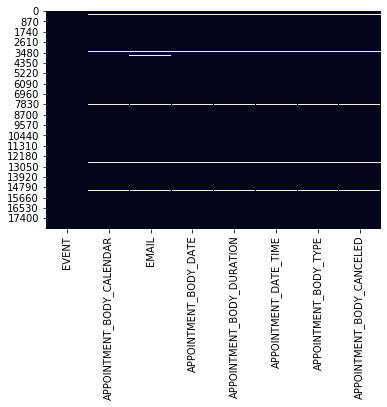

In [7]:
# Check for null values
sns.heatmap(silver_acuity.isnull(), cbar=False)

In [8]:
silver_acuity['EVENT'].value_counts()

appointment_changed        13582
appointment_scheduled       3838
appointment_rescheduled      516
appointment_canceled         321
Name: EVENT, dtype: int64

In [9]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      15039
Hair Mineral Analysis Appointment       2319
Follow Up Consultation                   479
Customer consultation                    111
Case Study                                16
Hair Mineral Analysis - Acquisition       15
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [10]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    3729
Name: EVENT, dtype: int64

In [11]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     3459
False     270
Name: Complete, dtype: int64

In [12]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')
# silver_acuity.info()

In [13]:
# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    3459
Name: Complete, dtype: int64

In [14]:
# Group by email 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

EVENT    0
dtype: int64

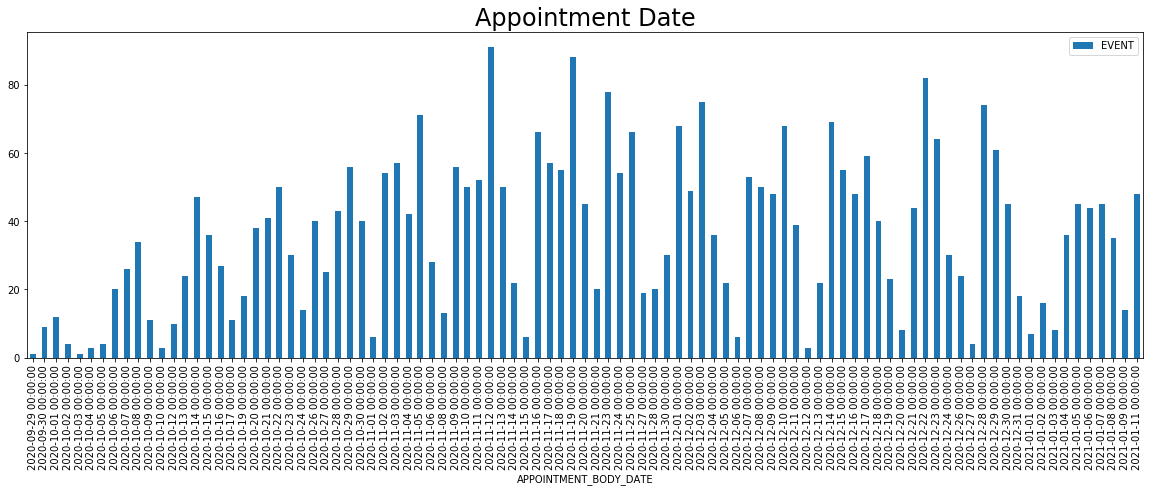

In [15]:
chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

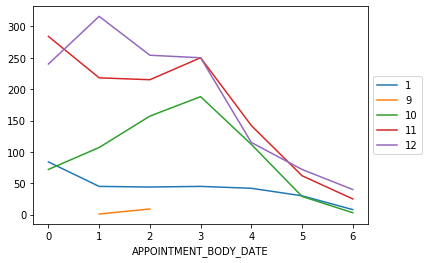

In [16]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [17]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-09-29 00:00:00')

In [18]:
max(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2021-01-11 00:00:00')

In [118]:
silver_acuity['APPOINTMENT_BODY_DURATION'].value_counts()

20.0    2934
30.0     425
15.0     100
Name: APPOINTMENT_BODY_DURATION, dtype: int64

In [124]:


silver_acuity.loc[silver_acuity['EMAIL']=='crystal.chatraw@yahoo.com']

,EVENT,APPOINTMENT_BODY_CALENDAR,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_CANCELED,Today,Complete
97,appointment_scheduled,"Dr. Lauren Geyman, ND",crystal.chatraw@yahoo.com,2020-11-09,20.0,2020-11-09 10:40:00.000,Hair Consultation,False,2021-01-12,True
2139,appointment_scheduled,"Dr. Kali Olsen, ND",crystal.chatraw@yahoo.com,2020-10-21,20.0,2020-10-21 10:00:00.000,Hair Consultation,False,2021-01-12,True
14934,appointment_scheduled,"Dr. Lauren Geyman, ND",crystal.chatraw@yahoo.com,2020-11-09,20.0,2020-11-09 16:05:00.000,Hair Consultation,False,2021-01-12,True


## SUB

In [99]:
gold_sub = pd.read_csv('GOLD.csv')
gold_sub.head()

,SUBSCRIPTION_ID,CUSTOMER_ID,EMAIL,COHORT_PERIOD_KEY,COHORT_START,COHORT_START_PST,PERIOD,PERIOD_START,PERIOD_END,PERIOD_HAS_ORDER,...,ITEM_PRODUCT_ID,ITEM_TARGETED_BOOSTERS,ITEM_BILLING_INTERVAL,ITEM_SHIPPING_INTERVAL,FIRST_ORDER_AT,LAST_QUIZ_TS,QUIZ_TYPE,TOTAL_ORDERS,TOTAL_ORDER_VALUE,QUIZ_TAKEN
0,560406,494151,narine786@gmail.com,2020-11-01-000,2020-11-01,2020-11-01 15:17:12.000,0,2020-11-01,2020-12-01,True,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
1,560406,494151,narine786@gmail.com,2020-11-01-001,2020-11-01,2020-11-01 15:17:12.000,1,2020-12-01,2020-12-31,True,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
2,560406,494151,narine786@gmail.com,2020-11-01-002,2020-11-01,2020-11-01 15:17:12.000,2,2020-12-31,2021-01-30,False,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
3,529729,465433,dmukh74@gmail.com,2020-10-01-000,2020-10-05,2020-10-05 21:20:03.000,0,2020-10-05,2020-11-04,True,...,33,Core Women,1 month,1 month,2020-10-05 21:19:56.000,NaN,NaN,4.0,948.0,0
4,529729,465433,dmukh74@gmail.com,2020-10-01-001,2020-10-05,2020-10-05 21:20:03.000,1,2020-11-04,2020-12-04,True,...,33,Core Women,1 month,1 month,2020-10-05 21:19:56.000,NaN,NaN,4.0,948.0,0


In [100]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.head()

,SUBSCRIPTION_ID,CUSTOMER_ID,EMAIL,COHORT_PERIOD_KEY,COHORT_START,COHORT_START_PST,PERIOD,PERIOD_START,PERIOD_END,PERIOD_HAS_ORDER,...,ITEM_PRODUCT_ID,ITEM_TARGETED_BOOSTERS,ITEM_BILLING_INTERVAL,ITEM_SHIPPING_INTERVAL,FIRST_ORDER_AT,LAST_QUIZ_TS,QUIZ_TYPE,TOTAL_ORDERS,TOTAL_ORDER_VALUE,QUIZ_TAKEN
0,560406,494151,narine786@gmail.com,2020-11-01-000,2020-11-01,2020-11-01 15:17:12.000,0,2020-11-01,2020-12-01,True,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
1,560406,494151,narine786@gmail.com,2020-11-01-001,2020-11-01,2020-11-01 15:17:12.000,1,2020-12-01,2020-12-31,True,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
2,560406,494151,narine786@gmail.com,2020-11-01-002,2020-11-01,2020-11-01 15:17:12.000,2,2020-12-31,2021-01-30,False,...,45,"Core Women, Hairbiotic, Stress Adaptogen",1 month,1 month,2020-11-01 15:17:07.000,2020-11-20 17:31:33.400,current,5.0,455.0,0
3,529729,465433,dmukh74@gmail.com,2020-10-01-000,2020-10-05,2020-10-05 21:20:03.000,0,2020-10-05,2020-11-04,True,...,33,Core Women,1 month,1 month,2020-10-05 21:19:56.000,NaN,NaN,4.0,948.0,0
4,529729,465433,dmukh74@gmail.com,2020-10-01-001,2020-10-05,2020-10-05 21:20:03.000,1,2020-11-04,2020-12-04,True,...,33,Core Women,1 month,1 month,2020-10-05 21:19:56.000,NaN,NaN,4.0,948.0,0


In [101]:
# Drop unneeded columns
gold.drop(columns=['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'COHORT_PERIOD_KEY',
       'COHORT_START', 'COHORT_START_PST', 'PERIOD', 'PERIOD_START',
       'PERIOD_END', 'PERIOD_HAS_ORDER', 'STATUS_CHANGED_AT',
       'COUNT_BILLED_IN_PERIOD', 'FIRST_COUPON_CODE', 'CUSTOMER_STORE_CREDIT',
       'FIRST_COUPON_TS', 'FIRST_COUPON_DISCOUNT',
       'FIRST_COUPON_FINANCE_GROUPING', 'FIRST_COUPON_MARKETING_INITIATIVE',
       'FIRST_COUPON_MARKETING_INITIATIVE_CHANNEL',
       'FIRST_COUPON_PURCHASE_TYPE', 'ALL_COUPONS',
       'PREVIOUS_RETENTION_STATUS', 'CURRENT_RETENTION_STATUS',
       'RETENTION_STATUS', 'SUBSCRIPTION_RECONCILE_END', 'CREATED_AT',
       'ORDER_TYPE', 'ITEM_SKU', 'ITEM_GROUP',
       'TOTAL_ITEMS', 'ITEM_SUB_TYPE', 'ITEM_SKU_TYPE',
       'ITEM_PRODUCT_CORE_CATEGORY', 'ITEM_PRODUCT_ID', 'ITEM_BILLING_INTERVAL',\
       'ITEM_SHIPPING_INTERVAL', 'FIRST_MAGENTO_COUPON_DISCOUNT', 'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE'], inplace=True)

In [102]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold['LAST_QUIZ_TS'] = pd.to_datetime(gold['LAST_QUIZ_TS'])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82335 entries, 0 to 82334
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   EMAIL                   82335 non-null  object        
 1   STATUS                  54201 non-null  object        
 2   ITEM_NAME               80695 non-null  object        
 3   ITEM_GENDER             80695 non-null  object        
 4   GROSS_ORDER_VALUE       80695 non-null  float64       
 5   ITEM_TARGETED_BOOSTERS  80695 non-null  object        
 6   FIRST_ORDER_AT          82335 non-null  datetime64[ns]
 7   LAST_QUIZ_TS            32873 non-null  datetime64[ns]
 8   QUIZ_TYPE               32873 non-null  object        
 9   QUIZ_TAKEN              82335 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 6.3+ MB


Timestamp('2020-09-28 00:43:09')

In [105]:
max(gold['FIRST_ORDER_AT'])

Timestamp('2021-01-05 22:02:31')

In [108]:
# AGG
df = gold.loc[gold.groupby('EMAIL')['FIRST_ORDER_AT'].idxmin()]
df.shape

(27030, 10)

In [109]:
min(df['FIRST_ORDER_AT'])

Timestamp('2020-09-28 00:43:09')

## Merge

In [110]:
sub1 = pd.merge(silver_acuity,df,how='left',on='EMAIL')

In [111]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT', 'LAST_QUIZ_TS',\
           'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE']]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3458
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EMAIL                  3459 non-null   object        
 1   APPOINTMENT_BODY_DATE  3459 non-null   datetime64[ns]
 2   FIRST_ORDER_AT         1220 non-null   datetime64[ns]
 3   LAST_QUIZ_TS           695 non-null    datetime64[ns]
 4   ITEM_NAME              1218 non-null   object        
 5   ITEM_GENDER            1218 non-null   object        
 6   GROSS_ORDER_VALUE      1218 non-null   float64       
dtypes: datetime64[ns](3), float64(1), object(3)
memory usage: 216.2+ KB


In [113]:
max(sub['FIRST_ORDER_AT'])

NaT

In [93]:
#Round to the day
# sub['APPOINTMENT_BODY_DATE'] = sub['APPOINTMENT_BODY_DATE'].dt.round('D')
# sub['FIRST_ORDER_AT'] = sub['FIRST_ORDER_AT'].dt.round('D')
# sub['LAST_QUIZ_TS'] = sub['LAST_QUIZ_TS'].dt.round('D')

# # create start year column to be able to make years_working column
# df['start_year'] = df['Agency Start Date'].apply(lambda x: int(x[6:]))
# df['years_with_city'] = df[['Fiscal Year']].sub(df['start_year'], axis=0)

# sub.loc[sub['FIRST_ORDER_AT']=='NaT', 'FIRST_ORDER_AT']= np.nan 
# sub.dropna(inplace = True)
# sub.info()

In [114]:
sub['TimeDifference'] = \
(((sub['FIRST_ORDER_AT']))-(sub['APPOINTMENT_BODY_DATE']))
sub.head()

,EMAIL,APPOINTMENT_BODY_DATE,FIRST_ORDER_AT,LAST_QUIZ_TS,ITEM_NAME,ITEM_GENDER,GROSS_ORDER_VALUE,TimeDifference
0,hunterelliott510@gmail.com,2020-12-29,NaT,NaT,NaN,NaN,NaN,NaT
1,ashleynizzle@yahoo.com,2021-01-06,2020-12-07 18:53:45,NaT,Nutrafol for Women + Hairbiotic + Stress Adapt...,Women,99.0,-30 days +18:53:45
2,foxbody1986@hotmail.com,2020-12-07,2020-11-30 21:25:18,NaT,Nutrafol for Women's Balance + Hairbiotic + St...,Women,99.0,-7 days +21:25:18
3,anbavitz@gmail.com,2020-12-22,2020-11-19 16:52:59,NaT,Nutrafol for Women's Balance,Women,79.0,-33 days +16:52:59
4,jsw107@georgetown.edu,2020-10-30,NaT,NaT,NaN,NaN,NaN,NaT


In [115]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3458
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   EMAIL                  3459 non-null   object         
 1   APPOINTMENT_BODY_DATE  3459 non-null   datetime64[ns] 
 2   FIRST_ORDER_AT         1220 non-null   datetime64[ns] 
 3   LAST_QUIZ_TS           695 non-null    datetime64[ns] 
 4   ITEM_NAME              1218 non-null   object         
 5   ITEM_GENDER            1218 non-null   object         
 6   GROSS_ORDER_VALUE      1218 non-null   float64        
 7   TimeDifference         1220 non-null   timedelta64[ns]
dtypes: datetime64[ns](3), float64(1), object(3), timedelta64[ns](1)
memory usage: 243.2+ KB


In [31]:
stop

NameError: name 'stop' is not defined

In [ ]:
# # Group by email 
# chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'time difference':'count'})
# chart.isna().sum()

In [117]:
# Export data
sub.to_csv('sub.csv')